In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install accelerate
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
from collections import Counter
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from huggingface_hub import HfFolder, Repository
from sklearn.metrics import cohen_kappa_score
from datasets import Dataset, get_dataset_config_names
import polars as pl
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
from transformers import (AutoTokenizer,
                          TrainingArguments,
                          DataCollatorWithPadding,
                          Trainer,
                          AutoModelForSequenceClassification,
                           EarlyStoppingCallback
                          )
import regex as re
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from google.colab import userdata
import ctypes, torch, gc, yaml,  joblib, spacy, multiprocessing, os, random, functools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [4]:
key_ = userdata.get('HF_TOKEN')
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_path = '/content/drive/MyDrive/essay/data/train.csv'
libc = ctypes.CDLL("libc.so.6")

cuda


In [5]:
args_no = 2
args = f'/content/drive/MyDrive/essay/args/args_{args_no}.yaml'

with open(args, 'r') as file:
  config = yaml.safe_load(file)


In [6]:

def clear_memory():
    libc.malloc_trim(0)
    torch.cuda.empty_cache()
    gc.collect()



In [7]:
lbl_mapping = { j: i for i, j in enumerate(config['lbl'])}


df_full = (pl.scan_csv(train_path)
        .with_columns(
            score = pl.col('score')
            .replace(lbl_mapping)
        )
      )


In [8]:
def initialize_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

initialize_seeds(config['seed'])

In [9]:


class text_prep():
  def __init__(self,
               df,
               tokenizer,
               max_length = config['max_length'],
               batch_size = config['batch_size'],
               stride = config['stride']
               ):

    self.set_df(df)
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.batch_size  = batch_size
    self.stride = stride

  def tokenize_function(self, batch):
    try:
        input_ids = []
        essay_id = []
        attention_mask = []
        full_text = []
        score = []
        txts = [self.preprocess_text(i) for i in batch['full_text']]

        for count_id , txt in enumerate(txts):
          tokenized = self.tokenizer(txt,
                                    max_length=self.max_length,
                                    return_overflowing_tokens = True,
                                    stride = self.stride,
                                    truncation=True
                                    )


          for count, input in enumerate(tokenized['input_ids']):
            full_text.append(txt)
            score.append(batch['score'][count_id])
            essay_id.append(batch['essay_id'][count_id])
            input_ids.append(input)
            attention_mask.append(tokenized['attention_mask'][count])

        return {
            'essay_id': essay_id,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'full_text': full_text,
            'score': score
        }
    except Exception as e:
        print(f"Error tokenizing batch: {batch}")
        raise e

  def preprocess_text(self, text):
    text = text.replace('\xa0', ' ')
    text = re.sub(r"[^a-zA-Z0-9\s,.'!?;:-]", '', text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

  def set_df(self, val):
    if isinstance(val, Dataset):
      self.df = val
    elif isinstance(val, pl.DataFrame):
      arrow_table = val.to_arrow()
      self.df = Dataset(arrow_table)
    else:
      raise TypeError("Unsupported data")



  def fit_transform(self):
     return (self.df.map(self.tokenize_function,
                         num_proc=multiprocessing.cpu_count() -1,
                         batched = True
                         )
                    .rename_column('score', 'labels')
     )


In [10]:

def token_df(tokenizer, df_full):
  df_sample = df_full.collect()
  tp = text_prep(df_sample, tokenizer = tokenizer)
  return tp.fit_transform()


In [11]:

def class_report(pred_df, fold):
  return (pd.DataFrame(classification_report(pred_df["labels"],
                                      pred_df["new_lbl"],
                                      output_dict = True))
  .T
  .iloc[0:6]
  .rename(
      columns = {'f1-score': f'fold_{fold}_f1'}
  )
  .loc[:, f'fold_{fold}_f1']
  )


In [12]:

def confusion(scoring):
  labels = sorted(scoring[:, 'labels'].unique().to_list())


  cm = confusion_matrix(scoring[:, "labels"].to_list(),
                        scoring[:, "new_lbl"].to_list(),
                        labels=labels,
                        )
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  ax = disp.ax_
  plt.xticks(range(len(labels)), labels, rotation=90, ha='right')
  plt.subplots_adjust(bottom=0.2)
  plt.show()


In [13]:
class PredictionProcess:
    def __init__(self, best_model, pad_to_multiple_of, device, batch_size, tokenizer):
        self.model = AutoModelForSequenceClassification.from_pretrained(best_model).to(device)
        self.data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=pad_to_multiple_of)
        self.batch_size = batch_size
        self.device = device


    @staticmethod
    def predict(batch, model, data_collator, device):
        collated_batch = data_collator({k: batch[k]
                                for k in batch
                                if k in ['input_ids', 'attention_mask']}
                              )

        input_ids = collated_batch['input_ids'].to(device)
        attention_mask = collated_batch['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().tolist()
        pred_labels = outputs.logits.argmax(dim=-1).cpu().tolist()
        return {'pred_labels': pred_labels, 'probabilities': probabilities}


    def _most_common(self, lst):
        counts = Counter(lst)
        max_frequency = max(counts.values())
        return [e for e, c in counts.items() if c == max_frequency]


    def _vote_pred(self, r):
      lbl_agg = r['lbl_agg']
      max_value_agg = r['max_value_agg']

      if len(lbl_agg) > 1:
        mc = self._most_common(lbl_agg)
        val_dic = {}
        data = list(zip(lbl_agg, max_value_agg))

        if len(mc) > 1:
          for i in mc:
            val_dic[i] = max(val for lbl, val in data if i == lbl)
        else:
          val_dic[mc[0]] = max(val for lbl, val in data if mc[0] == lbl)

        max_lbl = max(val_dic, key=val_dic.get)
        return {'new_lbl': max_lbl, 'val': val_dic[max_lbl]}
      else:
        return {'new_lbl': lbl_agg[0], 'val': max_value_agg[0]}




    def predict_dataset(self, dataset):
        self.model.eval()
        predict_partial = functools.partial(self.predict,
                                  model=self.model,
                                  data_collator=self.data_collator,
                                  device=self.device
                                  )
        pred = dataset.map(
            predict_partial,
            batched=True,
            batch_size=self.batch_size,
            remove_columns=['input_ids', 'attention_mask']
        )

        raw_pred = pred.to_polars()

        clear_memory()


        return (
              (raw_pred
              .with_columns(
                      max_value = pl.col('probabilities').list.max(),
              )
              .group_by('essay_id')
                .agg(
                    lbl_agg = pl.col('pred_labels'),
                    max_value_agg = pl.col('max_value')
                )
                  .with_columns(
                      temp = pl.struct(['lbl_agg', 'max_value_agg'])
                               .map_elements(lambda g: self._vote_pred(g))
               )
                .unnest('temp')
                .drop(['max_value_agg', 'lbl_agg'])
             ).join(
                 (raw_pred
                 .select(['essay_id', 'labels', 'full_text'])
                 .unique()
                 )
                 , on = 'essay_id'
             )
        )


In [14]:

essay_id = list(set(df_full.collect()['essay_id']))

df_pd = (
        df_full
        .filter(pl.col('essay_id').is_in(essay_id))
        .collect()
        .to_pandas()
       )


In [15]:


df_dic = {}
stratified_kfold = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=config['seed'])
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(df_pd, df_pd['score'])):

    print(f'fold number: {fold}')
    model_path = f"{config['best_model']}{args_no}_{config['base_model']}_{fold}"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    df = token_df(tokenizer, df_full)

    train_index, val_index = train_test_split(train_index, test_size=0.2, random_state=config['seed'])

    test_df = df.filter(lambda f: f['essay_id'] in df_pd.iloc[test_index].loc[:, 'essay_id'].to_list())

    predict = PredictionProcess(
                                best_model = model_path,
                                pad_to_multiple_of = config['pad_to_multiple_of'],
                                device = device,
                                batch_size = config['batch_size'],
                                tokenizer = tokenizer
                                )
    pred_df = predict.predict_dataset(test_df)
    kappa = cohen_kappa_score(pred_df["labels"], pred_df["new_lbl"], weights="quadratic")
    df_dic[fold] = {'df':pred_df,
                    'qwk': kappa,
                    'cm': class_report(pred_df, fold)
                   }





fold number: 0


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=7):   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22406 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Map:   0%|          | 0/4463 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fold number: 1


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=7):   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22406 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Map:   0%|          | 0/4481 [00:00<?, ? examples/s]

fold number: 2


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=7):   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22406 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fold number: 3


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=7):   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22406 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Map:   0%|          | 0/4491 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fold number: 4


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=7):   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22406 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Map:   0%|          | 0/4471 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# df_dic[0]
pl.DataFrame({
    'fold': [i for i, j in df_dic.items()],
    'qwk': [j['qwk'] for i, j in df_dic.items()],

})


fold,qwk
i64,f64
0,0.74342
1,0.753699
2,0.756292
3,0.783037
4,0.76913


fold_0


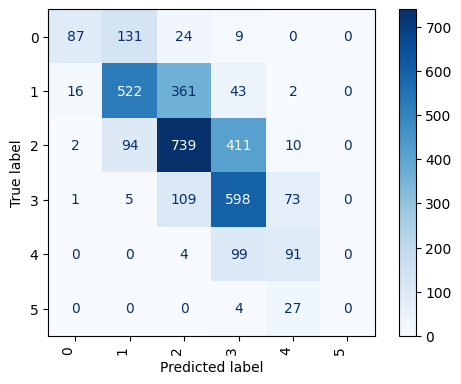

fold_1


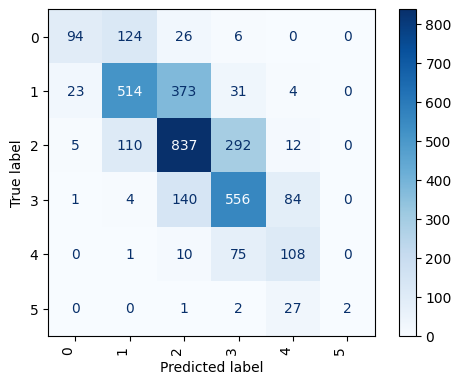

fold_2


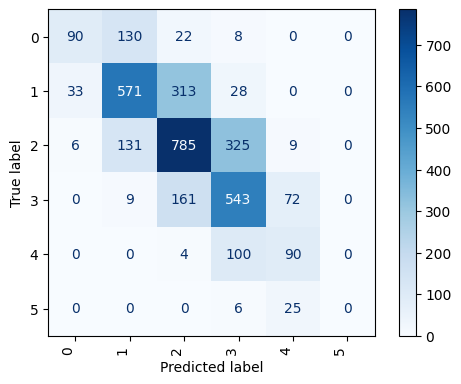

fold_3


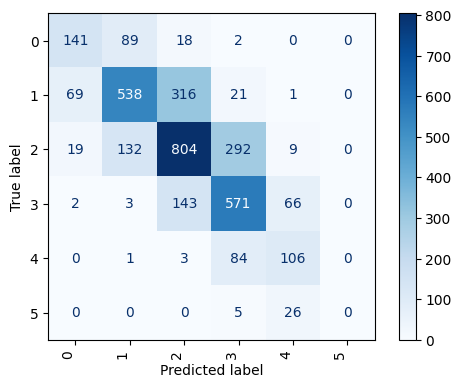

fold_4


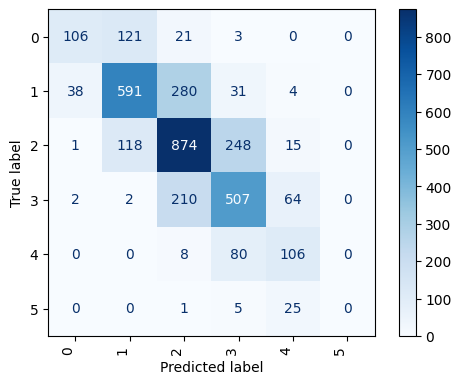

In [18]:
for i, j in df_dic.items():
  print(f'fold_{i}')
  confusion(j['df'])


In [19]:
pd.concat([j['cm'] for _, j in df_dic.items()], axis = 1)

,fold_0_f1,fold_1_f1,fold_2_f1,fold_3_f1,fold_4_f1
0,0.487395,0.504021,0.474934,0.586279,0.532663
1,0.615566,0.605418,0.639418,0.629977,0.665541
2,0.592860,0.633371,0.617867,0.633071,0.659623
3,0.613333,0.636520,0.605014,0.648864,0.611212
4,0.458438,0.503497,0.461538,0.527363,0.519608
5,0.000000,0.117647,0.000000,0.000000,0.000000
